In [1]:
import pandas as pd  
import numpy as np
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline   
#正常显示画图时出现的中文和负号
from pylab import mpl    
mpl.rcParams['figure.figsize'] = 13, 8
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

这里重点是Analyzers模块的调用与结果输出，调用模块是cerebro.addanalyzer()，再从模块中获取分析指标，如夏普比率是bt.analyzers.SharpeRatio
然后是给该指标重命名方便之后调用，即 _name='SharpeRatio'。
要获取分析指标，需要先执行回测系统，cerebro.run()，并将回测结果赋值给变量results，分析指标存储在results[0]里 (strat变量代替)，通过strat.analyzers.SharpeRatio.get_analysis()即可获取相应数据，其他指标操作方法类似。

In [2]:
#datapath=r'D:\Baiducloud\12M8-202005\1MIN\EURUSD_M1.csv'    #windows
datapath=r'D:\Baiducloud\12M8-202007\EURUSD_D1.csv'          #windows
#datapath=r'/Users/nilei/Nutstore/Data/EURUSD_M1.csv'         #macos
#datapath=r'/Users/nilei/Nutstore/Data/EURUSD_D1.csv'         #macos
dt=pd.read_csv(datapath)
dt.rename(columns={'Time (UTC)':'Date'},inplace=True)
dt.index=pd.to_datetime(dt.Date)
dt.drop(columns='Date',inplace=True)
dt.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-01,1.43283,1.43356,1.43181,1.43335,76787.4
2010-01-03,1.43295,1.43359,1.42910,1.43141,6331.3
2010-01-04,1.43143,1.44556,1.42559,1.44244,80019.4
2010-01-05,1.44238,1.44834,1.43445,1.43634,79887.1
2010-01-06,1.43638,1.44342,1.42807,1.44005,80971.8


In [3]:
#数据太大，选择合适的时间段进行回测
dt_1=dt['2017-1-1':'2020-10-3']
import datetime as datetime
data = bt.feeds.PandasData(dataname=dt_1,                               
                            fromdate=datetime.datetime(2020, 6, 1),                               
                            todate=datetime.datetime(2020, 6, 30) )           #这里面要尤其注意

In [4]:
# R测试策略
class MyStrategy(bt.Strategy):
    params=(('short',30),                   # RSI的下限
            ('long',70),)                   # RSI的上限

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < self.params.short:
                self.buy()
        
        else: 
            if self.rsi > self.params.long:
                self.sell()

In [5]:
def runstrat():    
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=True)

    # Add a strategy
    strats = cerebro.addstrategy(MyStrategy)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
    
    # Add a writerfile
    #cerebro.addwriter(bt.WriterFile, out='/Users/nilei/Nutstore/Data/EURUSD_Result.csv',csv=True, rounding=5)
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.0)
    
    #添加两个分析指标
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')   #夏普率
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')              #回撤
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.4f' % cerebro.broker.getvalue())
    
    # Run over everything
    ret=cerebro.run()
    resluts=ret[0]   #保存结果以便获取指标
    
    
    # Print out the final result
    print('Final Portfolio Value: %.4f' % cerebro.broker.getvalue())
    
    cerebro.plot(volume=False)
    
    
    #提取指标并打印出来
    print('SR:', resluts.analyzers.SharpeRatio.get_analysis())
    print('DW:', resluts.analyzers.DW.get_analysis())
    print(type(resluts.analyzers.DW.get_analysis()))

Starting Portfolio Value: 100000.0000
Final Portfolio Value: 100000.0000


<IPython.core.display.Javascript object>


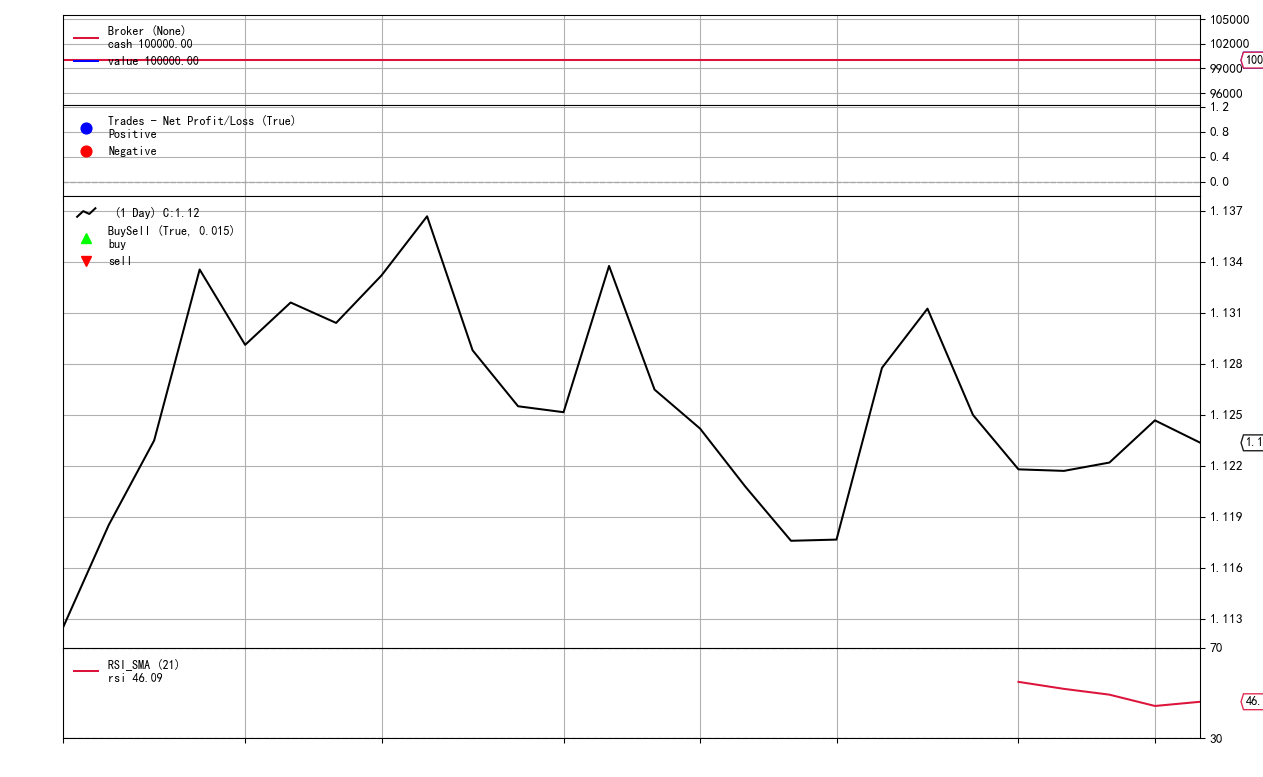

SR: OrderedDict([('sharperatio', None)])
DW: AutoOrderedDict([('len', 0), ('drawdown', 0.0), ('moneydown', 0.0), ('max', AutoOrderedDict([('len', 0.0), ('drawdown', 0.0), ('moneydown', 0.0)]))])
<class 'backtrader.utils.autodict.AutoOrderedDict'>


In [6]:
runstrat()